In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# API
from nats_bench import create

# custom modules
from custom.tss_model import TinyNetwork
from xautodl.models.cell_searchs.genotypes import Structure
from ZeroShotProxy import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
parser = argparse.ArgumentParser("Training-free NAS on NAS-Bench-201 (NATS-Bench-TSS)")
parser.add_argument("--data_path", type=str, default='./cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space", type=str, default='tss', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./configs/nas-benchmark/algos/weight-sharing.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--affine", type=int, default=1, choices=[0, 1], help="Whether use affine=True or False in the BN layer.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")

# log
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")

# custom
parser.add_argument("--gpu", type=int, default=0, help="")
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
#parser.add_argument("--api_data_path", type=str, default="/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-full/data/NATS-tss-v1_0-3ffb9-full", help="")
parser.add_argument("--api_data_path", type=str, default="/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/", help="")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument('--zero_shot_score', type=str, default='vkdnw', choices=['az_nas','zico','zen','gradnorm','naswot','synflow','snip','grasp','te_nas','gradsign'])
parser.add_argument("--rand_seed", type=int, default=1, help="manual seed (we use 1-to-5)")
args = parser.parse_args(args=[])

if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

print(args.rand_seed)
print(args)
xargs=args

1
Namespace(affine=1, api_data_path='/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', channel=16, config_path='./configs/nas-benchmark/algos/weight-sharing.config', data_path='./cifar.python', dataset='cifar10', gpu=0, max_nodes=4, num_cells=5, print_freq=200, rand_seed=1, save_dir='./results/tmp', search_space='tss', track_running_stats=0, workers=4, zero_shot_score='vkdnw')


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
affine           : 1
api_data_path    : /mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/
channel          : 16
config_path      : ./configs/nas-benchmark/algos/weight-sharing.config
data_path        : ./cifar.python
dataset          : cifar10
gpu              : 0
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 1
save_dir         : ./results/tmp
search_space     : tss
track_running_stats : 0
workers          : 4
zero_shot_score  : vkdnw
Python  Version  : 3.8.20 (default, Oct  3 2024, 15:24:27)  [GCC 11.2.0]
Pillow  Version  : 10.4.0
PyTorch Version  : 2.0.1
cuDNN   Version  : 8500
CUDA available   : True
CUDA GPU numbers : 1
CUDA_VISIBLE_DEVICES : 0


In [4]:
## API
api = create(xargs.api_data_path, xargs.search_space, fast_mode=True, verbose=False)
logger.log("Create API = {:} done".format(api))

## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                                   valid_data,
                                                                   xargs.dataset,
                                                                   "./configs/nas-benchmark/",
                                                                   (config.batch_size, config.test_batch_size),
                                                                   xargs.workers,)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

## model
search_space = get_search_spaces(xargs.search_space, "nats-bench")
logger.log("search space : {:}".format(search_space))

device = torch.device('cuda:{}'.format(xargs.gpu))

Create API = NATStopology(0/15625 architectures, fast_mode=True, file=) done
Files already downloaded and verified
Files already downloaded and verified
./configs/nas-benchmark/algos/weight-sharing.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
search space : ['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']


/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
def random_genotype(max_nodes, op_names):
    genotypes = []
    for i in range(1, max_nodes):
        xlist = []
        for j in range(i):
            node_str = "{:}<-{:}".format(i, j)
            op_name = random.choice(op_names)
            xlist.append((op_name, j))
        genotypes.append(tuple(xlist))
    arch = Structure(genotypes)
    return arch

real_input_metrics = ['vkdnw', 'zico', 'snip', 'grasp', 'te_nas', 'gradsign', 'jacov']
    
def search_find_best(xargs, xloader, n_samples = None, archs = None):
    logger.log("Searching with {}".format(xargs.zero_shot_score.lower()))
    score_fn_name = "compute_{}_score".format(xargs.zero_shot_score.lower())
    score_fn = globals().get(score_fn_name)
    input_, target_ = next(iter(xloader))
    resolution = input_.size(2)
    batch_size = input_.size(0)
    zero_shot_score_dict = None
    arch_list = []
    if xargs.zero_shot_score.lower() in real_input_metrics:
        print('Use real images as inputs')
        trainloader = train_loader
    else:
        print('Use random inputs')
        trainloader = None
        
    if archs is None and n_samples is not None:
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for i in tqdm.tqdm(range(n_samples)):
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            # random sampling
            arch = random_genotype(xargs.max_nodes, search_space)
            network = TinyNetwork(xargs.channel, xargs.num_cells, arch, class_num)
            network = network.to(device)
            network.train()

            start.record()
            

            info_dict = score_fn.compute_nas_score(network, gpu=xargs.gpu, trainloader=trainloader, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
#             all_mem.append(torch.cuda.max_memory_reserved())
            all_mem.append(torch.cuda.max_memory_allocated())

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        logger.log("------Runtime------")
        logger.log("All: {:.5f} ms".format(np.mean(all_time)))
        logger.log("------Avg Mem------")
        logger.log("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        logger.log("------Max Mem------")
        logger.log("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    elif archs is not None and n_samples is None:
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for arch in tqdm.tqdm(archs):
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            network = TinyNetwork(xargs.channel, xargs.num_cells, arch, class_num)
            network = network.to(device)
            network.train()

            start.record()
            

            info_dict = score_fn.compute_nas_score(network, gpu=xargs.gpu, trainloader=trainloader, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
#             all_mem.append(torch.cuda.max_memory_reserved())
            all_mem.append(torch.cuda.max_memory_allocated())

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        logger.log("------Runtime------")
        logger.log("All: {:.5f} ms".format(np.mean(all_time)))
        logger.log("------Avg Mem------")
        logger.log("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        logger.log("------Max Mem------")
        logger.log("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    return arch_list, zero_shot_score_dict

In [6]:
def generate_all_archs(search_space, xargs):
    arch = random_genotype(xargs.max_nodes, search_space)
    archs = arch.gen_all(search_space, xargs.max_nodes, False)
    return archs

if os.path.exists("./tss_all_arch.pickle"):
    with open("./tss_all_arch.pickle", "rb") as fp:
        all_archs = pickle.load(fp)
else:
    all_archs = generate_all_archs(search_space, xargs)
    with open("./tss_all_arch.pickle", "wb") as fp:
        pickle.dump(all_archs, fp)

for zero_shot_score in ['gradsign', 'zico', 'zen','gradnorm','naswot','synflow','snip','grasp','te_nas', 'az_nas', 'zen', 'jacov', 'vkdnw']:
    xargs.zero_shot_score = zero_shot_score
    result_path = "./{}_{}_all_arch.pickle".format(xargs.zero_shot_score, xargs.dataset)
    if os.path.exists(result_path):
        print("results already exists")
        with open(result_path, "rb") as fp:
            results = pickle.load(fp)
        archs = all_archs
    else:
        archs, results = search_find_best(xargs, train_loader, archs=all_archs)
        with open(result_path, "wb") as fp:
            pickle.dump(results, fp)

results already exists
results already exists
results already exists
results already exists
results already exists
results already exists
results already exists
results already exists
results already exists
results already exists
results already exists
results already exists
results already exists


In [8]:
def get_results_from_api(api, arch, dataset='cifar10'):
    dataset_candidates = ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120']
    assert dataset in dataset_candidates
    index = api.query_index_by_arch(arch)
    api._prepare_info(index)
    archresult = api.arch2infos_dict[index]['200']
    
    if dataset == 'cifar10-valid':
        acc = archresult.get_metrics(dataset, 'x-valid', iepoch=None, is_random=False)['accuracy']
    elif dataset == 'cifar10':
        acc = archresult.get_metrics(dataset, 'ori-test', iepoch=None, is_random=False)['accuracy']
    else:
        acc = archresult.get_metrics(dataset, 'x-test', iepoch=None, is_random=False)['accuracy']
    flops = archresult.get_compute_costs(dataset)['flops']
    params = archresult.get_compute_costs(dataset)['params']
    
    return acc, flops, params

api_valid_accs, api_flops, api_params = [], [], []
for a in archs:
    try:
        valid_acc, flops, params = get_results_from_api(api, a, 'cifar10')
    #     valid_acc, flops, params = get_results_from_api(api, a, 'cifar100')
    #     valid_acc, flops, params = get_results_from_api(api, a, 'ImageNet16-120')
        api_valid_accs.append(valid_acc)
        api_flops.append(flops)
        api_params.append(params)
    except Exception as e:
        print(e)
    
print("Maximum acc: {}% \n Info".format(np.max(api_valid_accs)))
best_idx = np.argmax(api_valid_accs)
best_arch = archs[best_idx]
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

Maximum acc: 94.37333333333333% 
 Info
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=13714
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=20.34 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.99%], valid : [loss = 0.430 & top1 = 91.50%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=20.34 ms.
cifar10        train : [loss = 0.002 & top1 = 99.99%], test  : [loss = 0.272 & top1 = 94.37%]
cifar100       FLOP=153.28 M, Params=1.079 MB, latency=22.68 ms.
cifar100       train : [loss = 0.016 & top1 = 99.90%], valid : [loss = 1.283 & top1 = 73.31%], test : [loss = 1.282 & top1 = 73.09%]
ImageNet16-120 FLOP= 38.33 M, Params=1.081 MB, latency=18.75 ms.
ImageNet16-120 train : [loss = 1.064 & top1 = 70.31%], valid : [loss = 2.258 & top1 = 45.59%], test : [loss = 2.283 & top1 = 46.33%]


In [9]:
import pandas as pd
results_dicts = []
for zero_shot_score in ['gradsign', 'zico', 'gradnorm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas', 'az_nas', 'zen', 'jacov', 'vkdnw']:
    with open("./{}_{}_all_arch.pickle".format(zero_shot_score, xargs.dataset), "rb") as fp:
        results_dicts.append(pickle.load(fp))
results_all = pd.concat([pd.DataFrame(d) for d in results_dicts], axis=1)
results_all = pd.concat([results_all, pd.DataFrame({'val_acc': api_valid_accs, 'flops': api_flops})], axis=1)
results_all['arch_unique'] = [a.tostr() for a in all_archs]

results_all['vkdnw_ratio'] = -(results_all['vkdnw_lambda_8']/results_all['vkdnw_lambda_3']).apply(np.log)
results_all['az_nas'] = results_all['expressivity'].rank().apply(np.log)+results_all['progressivity'].rank().apply(np.log)+results_all['trainability'].rank().apply(np.log)+results_all['flops'].rank().apply(np.log)
results_all['vkdnw'] = results_all[['vkdnw_dim', 'vkdnw_ratio']].apply(tuple, axis=1).rank(method='dense', ascending=True).apply(np.log)+results_all['flops'].rank().apply(np.log)

results_all['vkdnw_a'] =  results_all[['vkdnw_dim', 'vkdnw_ratio']].apply(tuple, axis=1).rank(method='dense', ascending=True).apply(np.log)+results_all['progressivity'].rank().apply(np.log)+results_all['trainability'].rank().apply(np.log)+results_all['flops'].rank().apply(np.log)
results_all['vkdnw_b'] =  results_all['expressivity'].rank().apply(np.log)+results_all[['vkdnw_dim', 'vkdnw_ratio']].apply(tuple, axis=1).rank(method='dense', ascending=True).apply(np.log)+results_all['trainability'].rank().apply(np.log)+results_all['flops'].rank().apply(np.log)
results_all['vkdnw_c'] =  results_all['expressivity'].rank().apply(np.log)+results_all['progressivity'].rank().apply(np.log)+results_all[['vkdnw_dim', 'vkdnw_ratio']].apply(tuple, axis=1).rank(method='dense', ascending=True).apply(np.log)+results_all['flops'].rank().apply(np.log)
results_all['te_nas'] = results_all['ntk'].rank().apply(np.log)+results_all['linear_region'].rank().apply(np.log)

In [ ]:
# Option 1: keep only arch_unique (12751 nets)
#results_all = results_all.drop_duplicates(subset='arch_unique', keep='first')
# Option 2: do aggregation along 'arch_unique' (12751 nets); problem: vkdnw_dim is not unique
#results_all = results_all.groupby('arch_unique').mean()
# Option 2: keep only according to MFF (9445 nets)
results_all = results_all[results_all['arch_unique'].isin(list(pd.read_csv('../../GRAF/zc_combine/data/nb201_features.csv')['net_str']))]

gradsign
|skip_connect~0|+|skip_connect~0|none~1|+|none~0|skip_connect~1|avg_pool_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=5401
cifar10-valid  FLOP=  7.78 M, Params=0.073 MB, latency=9.15 ms.
cifar10-valid  train : [loss = 0.481 & top1 = 83.20%], valid : [loss = 0.640 & top1 = 78.47%]
cifar10        FLOP=  7.78 M, Params=0.073 MB, latency=9.15 ms.
cifar10        train : [loss = 0.513 & top1 = 82.15%], test  : [loss = 0.593 & top1 = 80.05%]
cifar100       FLOP=  7.79 M, Params=0.079 MB, latency=8.06 ms.
cifar100       train : [loss = 1.676 & top1 = 54.47%], valid : [loss = 1.842 & top1 = 50.75%], test : [loss = 1.870 & top1 = 50.79%]
ImageNet16-120 FLOP=  1.95 M, Params=0.080 MB, latency=8.50 ms.
ImageNet16-120 train : [loss = 3.324 & top1 = 21.26%], valid : [loss = 3.318 & top1 = 21.07%], test : [loss = 3.352 & top1 = 21.07%]
gradsign: -0.1287567739823473	-0.15324721317687445	-0.15324721317687445	


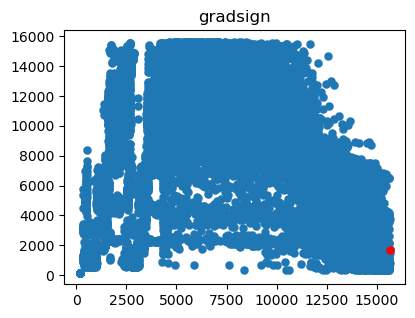

zico
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=1462
cifar10-valid  FLOP=220.12 M, Params=1.532 MB, latency=23.63 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.491 & top1 = 90.20%]
cifar10        FLOP=220.12 M, Params=1.532 MB, latency=23.63 ms.
cifar10        train : [loss = 0.002 & top1 = 99.97%], test  : [loss = 0.296 & top1 = 93.76%]
cifar100       FLOP=220.13 M, Params=1.537 MB, latency=22.58 ms.
cifar100       train : [loss = 0.024 & top1 = 99.79%], valid : [loss = 1.365 & top1 = 70.71%], test : [loss = 1.354 & top1 = 71.11%]
ImageNet16-120 FLOP= 55.04 M, Params=1.539 MB, latency=22.16 ms.
ImageNet16-120 train : [loss = 1.863 & top1 = 50.60%], valid : [loss = 2.316 & top1 = 40.78%], test : [loss = 2.311 & top1 = 41.44%]
zico: 0.5887250853535753	0.7836407923438452	0.7836407923438452	


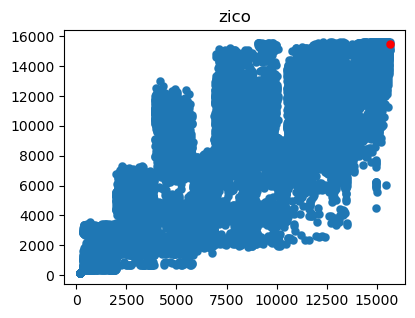

zen
|skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|skip_connect~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=10319
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=15.94 ms.
cifar10-valid  train : [loss = 0.035 & top1 = 99.37%], valid : [loss = 0.486 & top1 = 87.34%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=15.94 ms.
cifar10        train : [loss = 0.042 & top1 = 98.77%], test  : [loss = 0.368 & top1 = 90.65%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=15.42 ms.
cifar100       train : [loss = 0.494 & top1 = 85.75%], valid : [loss = 1.211 & top1 = 67.20%], test : [loss = 1.196 & top1 = 68.10%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=12.93 ms.
ImageNet16-120 train : [loss = 2.132 & top1 = 44.57%], valid : [loss = 2.332 & top1 = 39.62%], test : [loss = 2.359 & top1 = 40.77%]
zen: 0.29599627586421096	0.3854761661250238	0.3854761661250238	


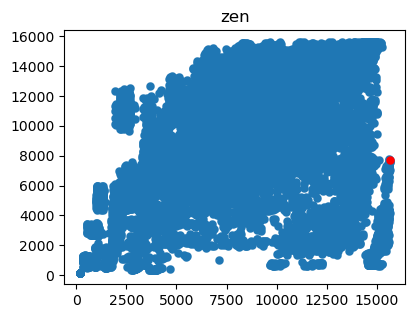

grad_norm
|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=818
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=17.96 ms.
cifar10-valid  train : [loss = 0.084 & top1 = 97.37%], valid : [loss = 0.610 & top1 = 84.39%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=17.96 ms.
cifar10        train : [loss = 0.097 & top1 = 96.80%], test  : [loss = 0.420 & top1 = 88.52%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=17.80 ms.
cifar100       train : [loss = 0.731 & top1 = 78.82%], valid : [loss = 1.528 & top1 = 59.88%], test : [loss = 1.523 & top1 = 60.02%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=16.56 ms.
ImageNet16-120 train : [loss = 4.334 & top1 = 5.39%], valid : [loss = 4.309 & top1 = 5.73%], test : [loss = 4.319 & top1 = 5.46%]
grad_norm: 0.35623731617755816	0.48399302076364226	0.48399302076364226	


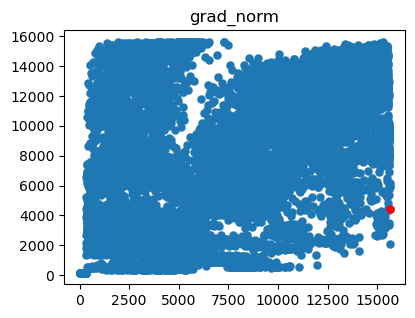

naswot
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=5636
cifar10-valid  FLOP= 62.83 M, Params=0.456 MB, latency=21.22 ms.
cifar10-valid  train : [loss = 0.006 & top1 = 99.93%], valid : [loss = 0.466 & top1 = 89.53%]
cifar10        FLOP= 62.83 M, Params=0.456 MB, latency=21.22 ms.
cifar10        train : [loss = 0.011 & top1 = 99.79%], test  : [loss = 0.298 & top1 = 92.67%]
cifar100       FLOP= 62.84 M, Params=0.462 MB, latency=21.43 ms.
cifar100       train : [loss = 0.220 & top1 = 94.63%], valid : [loss = 1.245 & top1 = 69.31%], test : [loss = 1.229 & top1 = 69.22%]
ImageNet16-120 FLOP= 15.72 M, Params=0.463 MB, latency=22.52 ms.
ImageNet16-120 train : [loss = 1.827 & top1 = 51.41%], valid : [loss = 2.159 & top1 = 43.96%], test : [loss = 2.195 & top1 = 43.63%]
naswot: 0.5560305548440485	0.7419794232472723	0.7419794232472723	


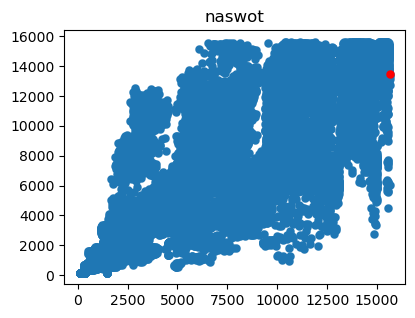

synflow
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=6420
cifar10-valid  FLOP=184.73 M, Params=1.289 MB, latency=22.43 ms.
cifar10-valid  train : [loss = 0.004 & top1 = 99.92%], valid : [loss = 0.561 & top1 = 88.93%]
cifar10        FLOP=184.73 M, Params=1.289 MB, latency=22.43 ms.
cifar10        train : [loss = 0.007 & top1 = 99.84%], test  : [loss = 0.373 & top1 = 92.09%]
cifar100       FLOP=184.74 M, Params=1.294 MB, latency=20.38 ms.
cifar100       train : [loss = 0.090 & top1 = 98.28%], valid : [loss = 1.513 & top1 = 66.43%], test : [loss = 1.505 & top1 = 67.37%]
ImageNet16-120 FLOP= 46.19 M, Params=1.296 MB, latency=19.08 ms.
ImageNet16-120 train : [loss = 2.442 & top1 = 37.32%], valid : [loss = 2.652 & top1 = 33.02%], test : [loss = 2.669 & top1 = 33.23%]
synflow: 0.5710886741320303	0.7686329488127219	0.7686329488127219	


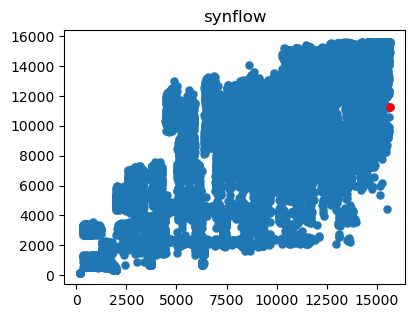

snip
|nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=818
cifar10-valid  FLOP=113.95 M, Params=0.802 MB, latency=17.96 ms.
cifar10-valid  train : [loss = 0.084 & top1 = 97.37%], valid : [loss = 0.610 & top1 = 84.39%]
cifar10        FLOP=113.95 M, Params=0.802 MB, latency=17.96 ms.
cifar10        train : [loss = 0.097 & top1 = 96.80%], test  : [loss = 0.420 & top1 = 88.52%]
cifar100       FLOP=113.96 M, Params=0.808 MB, latency=17.80 ms.
cifar100       train : [loss = 0.731 & top1 = 78.82%], valid : [loss = 1.528 & top1 = 59.88%], test : [loss = 1.523 & top1 = 60.02%]
ImageNet16-120 FLOP= 28.50 M, Params=0.810 MB, latency=16.56 ms.
ImageNet16-120 train : [loss = 4.334 & top1 = 5.39%], valid : [loss = 4.309 & top1 = 5.73%], test : [loss = 4.319 & top1 = 5.46%]
snip: 0.45362097026077247	0.6146865641585858	0.6146865641585858	


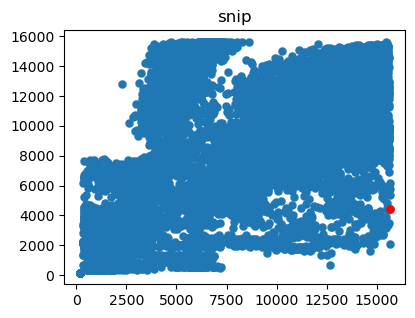

grasp
|nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|none~0|none~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=4992
cifar10-valid  FLOP= 19.58 M, Params=0.157 MB, latency=17.45 ms.
cifar10-valid  train : [loss = 0.389 & top1 = 86.72%], valid : [loss = 0.599 & top1 = 80.25%]
cifar10        FLOP= 19.58 M, Params=0.157 MB, latency=17.45 ms.
cifar10        train : [loss = 0.367 & top1 = 87.39%], test  : [loss = 0.483 & top1 = 83.82%]
cifar100       FLOP= 19.59 M, Params=0.163 MB, latency=16.30 ms.
cifar100       train : [loss = 1.712 & top1 = 53.34%], valid : [loss = 1.881 & top1 = 49.42%], test : [loss = 1.851 & top1 = 49.81%]
ImageNet16-120 FLOP=  4.90 M, Params=0.164 MB, latency=16.45 ms.
ImageNet16-120 train : [loss = 4.783 & top1 = 0.86%], valid : [loss = 4.792 & top1 = 0.83%], test : [loss = 4.792 & top1 = 0.83%]
grasp: 0.3149722073414168	0.4541455287568072	0.4541455287568072	


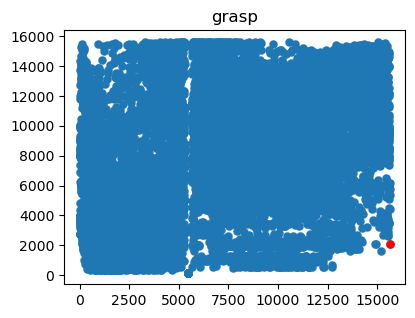

ntk
linear_region
|none~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7353
cifar10-valid  FLOP=149.34 M, Params=1.045 MB, latency=19.83 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.99%], valid : [loss = 0.427 & top1 = 91.01%]
cifar10        FLOP=149.34 M, Params=1.045 MB, latency=19.83 ms.
cifar10        train : [loss = 0.003 & top1 = 99.97%], test  : [loss = 0.284 & top1 = 93.68%]
cifar100       FLOP=149.35 M, Params=1.051 MB, latency=18.54 ms.
cifar100       train : [loss = 0.064 & top1 = 99.10%], valid : [loss = 1.398 & top1 = 69.77%], test : [loss = 1.320 & top1 = 70.37%]
ImageNet16-120 FLOP= 37.34 M, Params=1.053 MB, latency=14.95 ms.
ImageNet16-120 train : [loss = 1.543 & top1 = 58.27%], valid : [loss = 2.252 & top1 = 43.75%], test : [loss = 2.253 & top1 = 43.80%]
AZ-NAS: 0.6654811776529557	0.8544384481082261	0.8544384481082263	


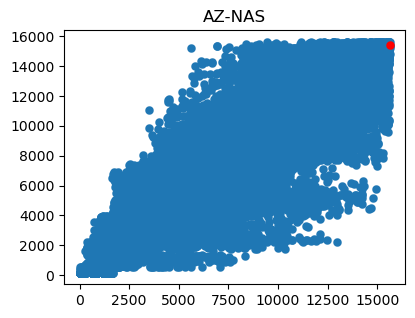

expressivity
progressivity
trainability
|skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=3558
cifar10-valid  FLOP=121.82 M, Params=0.858 MB, latency=21.29 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.494 & top1 = 90.09%]
cifar10        FLOP=121.82 M, Params=0.858 MB, latency=21.29 ms.
cifar10        train : [loss = 0.003 & top1 = 99.96%], test  : [loss = 0.298 & top1 = 93.63%]
cifar100       FLOP=121.82 M, Params=0.864 MB, latency=20.30 ms.
cifar100       train : [loss = 0.062 & top1 = 99.20%], valid : [loss = 1.288 & top1 = 70.54%], test : [loss = 1.281 & top1 = 70.60%]
ImageNet16-120 FLOP= 30.46 M, Params=0.866 MB, latency=19.05 ms.
ImageNet16-120 train : [loss = 1.568 & top1 = 57.66%], valid : [loss = 2.161 & top1 = 44.83%], test : [loss = 2.153 & top1 = 45.30%]
AZ-NAS: 0.7408056894696923	0.9126213937405534	0.91

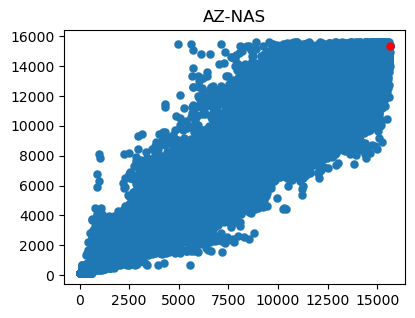

FileNotFoundError: [Errno 2] No such file or directory: './jacov_cifar10_all_arch.pickle'

In [33]:
for zero_shot_score in ['gradsign', 'zico', 'zen', 'gradnorm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas', 'az_nas', 'jacov', 'zen', 'vkdnw']:
    
    with open("./{}_{}_all_arch.pickle".format(zero_shot_score, xargs.dataset), "rb") as fp:
        results = pickle.load(fp)
    archs = all_archs
    
    if zero_shot_score == 'vkdnw':
        import pandas as pd
        results = pd.DataFrame(results)
        results['vkdnw_ratio'] = -(results['vkdnw_lambda_8']/results['vkdnw_lambda_3']).apply(np.log)
        results['vkdnw'] = results[['vkdnw_dim', 'vkdnw_ratio']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
        results = {'vkdnw': results['vkdnw']}

    fig_scale = 1.1
    
    if zero_shot_score.lower() == 'az_nas' or zero_shot_score.lower() == 'te_nas':
        rank_agg = None
        l = len(api_flops)
        rank_agg = np.log(stats.rankdata(api_flops) / l)
        for k in results.keys():
            print(k)
            if rank_agg is None:
                rank_agg = np.log( stats.rankdata(results[k]) / l)
            else:
                rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)
    
    
        best_idx = np.argmax(rank_agg)
    
        best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
        if api is not None:
            print("{:}".format(api.query_by_arch(best_arch, "200")))
    
    
        x = stats.rankdata(rank_agg)
        y = stats.rankdata(api_valid_accs)
        kendalltau = stats.kendalltau(x, y)
        spearmanr = stats.spearmanr(x, y)
        pearsonr = stats.pearsonr(x, y)
        print("AZ-NAS: {}\t{}\t{}\t".format(kendalltau[0], pearsonr[0], spearmanr[0]))
        plt.figure(figsize=(4*fig_scale,3*fig_scale))
        plt.scatter(x, y, linewidths=0.1)
        best_idx = np.argmax(rank_agg)
        plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
        plt.title("AZ-NAS")
        plt.show()
        
    elif zero_shot_score == 'te_nas':
        rank_agg = None
        for k in results.keys():
            print(k)
            if rank_agg is None:
                rank_agg = stats.rankdata(results[k])
            else:
                rank_agg = rank_agg + stats.rankdata(results[k])
    
    
        best_idx = np.argmax(rank_agg)
    
        best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
        if api is not None:
            print("{:}".format(api.query_by_arch(best_arch, "200")))
    
    
        x = stats.rankdata(rank_agg)
        y = stats.rankdata(api_valid_accs)
        kendalltau = stats.kendalltau(x, y)
        spearmanr = stats.spearmanr(x, y)
        pearsonr = stats.pearsonr(x, y)
        print("TE-NAS: {}\t{}\t{}\t".format(kendalltau[0], pearsonr[0], spearmanr[0]))
        plt.figure(figsize=(4*fig_scale,3*fig_scale))
        plt.scatter(x, y, linewidths=0.1)
        best_idx = np.argmax(rank_agg)
        plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
        plt.title("TE-NAS")
        plt.show()
    
    else:
        for k, v in results.items():
            print(k)
            best_idx = np.argmax(v)
    
            best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
            if api is not None:
                print("{:}".format(api.query_by_arch(best_arch, "200")))
    
            x = stats.rankdata(v)
            y = stats.rankdata(api_valid_accs)
            kendalltau = stats.kendalltau(x, y)
            spearmanr = stats.spearmanr(x, y)
            pearsonr = stats.pearsonr(x, y)
            print("{}: {}\t{}\t{}\t".format(k, kendalltau[0], pearsonr[0], spearmanr[0]))
            plt.figure(figsize=(4*fig_scale,3*fig_scale))
            plt.scatter(x, y, linewidths=0.1)
            best_idx = np.argmax(v)
            plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
            plt.title("{}".format(k))
            plt.show()

In [ ]:
# ### Confusion matrix

# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# import copy

# metrics = copy.deepcopy(results)

# metrics['accuracy'] = api_valid_accs
# metrics['complexity'] = api_flops

# # keys = ['accuracy', 'expressivity', 'progressivity', 'trainability', 'complexity']
# # key_names = ['Acc.', r"$s^{\mathcal{E}}$", r"$s^{\mathcal{P}}$", r"$s^{\mathcal{T}}$", r"$s^{\mathcal{C}}$"]
# keys = ['expressivity', 'progressivity', 'trainability', 'complexity']
# key_names = [r"$s^{\mathcal{E}}$", r"$s^{\mathcal{P}}$", r"$s^{\mathcal{T}}$", r"$s^{\mathcal{C}}$"]
# print(keys)

# matrix = np.zeros((len(keys),len(keys)))

# for i in range(len(keys)):
#     for j in range(len(keys)):
#         x = stats.rankdata(metrics[keys[i]])
#         y = stats.rankdata(metrics[keys[j]])
#         kendalltau = stats.kendalltau(x, y)[0]
#         matrix[i,j] = kendalltau

# print(matrix)
        
# df_cm = pd.DataFrame(matrix, index = [i for i in key_names], columns = [i for i in key_names])
# plt.figure(figsize=(6,3))
# sn.set(font_scale=1.9) # for label size
# ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 17}, cmap='GnBu', fmt='.2f') # font size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=16)
# plt.yticks(rotation=0) 
# plt.savefig('confusion_matrix.pdf', bbox_inches = 'tight', pad_inches = 0)
# plt.show()

In [ ]:
# #### Visualize scatter plots
# def visualize_proxy_cmap(x, y, title, save_name, ref_rank=None):
#     if ref_rank is None:
#         ref_rank = x
#     plt.figure(figsize=(4.5*1.5,3*1.5))
#     plt.grid(True, alpha=0.3)
#     plt.scatter(x,y, linewidths=0.1, c=ref_rank, cmap='viridis_r')
#     plt.xlabel("Predicted network ranking", fontsize=16)
#     plt.ylabel("Ground-truth network ranking", fontsize=16)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.colorbar()
#     plt.title(title, fontsize=20)
# #     plt.savefig('{}.pdf'.format(save_name), bbox_inches = 'tight', pad_inches = 0)
#     plt.show()
    
# def visualize_proxy(x, y, title, save_name):
#     plt.figure(figsize=(3.8*1.5,3*1.5))
#     plt.grid(True, alpha=0.3)
#     plt.scatter(x,y, linewidths=0.1, c="#140c86")
#     plt.xlabel("Predicted network ranking", fontsize=16)
#     plt.ylabel("Ground-truth network ranking", fontsize=16)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.title(title, fontsize=20)
# #     plt.savefig('{}.pdf'.format(save_name), bbox_inches = 'tight', pad_inches = 0)
#     plt.show()

# if xargs.zero_shot_score.lower() == 'az_nas':
#     rank_agg = None
#     l = len(api_flops)
#     rank_agg = np.log(stats.rankdata(api_flops) / l)
#     for k in results.keys():
#         print(k)
#         if rank_agg is None:
#             rank_agg = np.log( stats.rankdata(results[k]) / l)
#         else:
#             rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)


#     best_idx = np.argmax(rank_agg)

#     best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
#     if api is not None:
#         print("{:}".format(api.query_by_arch(best_arch, "200")))


#     x = stats.rankdata(rank_agg)
#     x_agg = x
#     y = stats.rankdata(api_valid_accs)
#     kendalltau = stats.kendalltau(x, y)
#     spearmanr = stats.spearmanr(x, y)
#     pearsonr = stats.pearsonr(x, y)
#     visualize_proxy(x,y,r"AZ-NAS ($\tau$={0:.3f}, $\rho$={1:.3f})".format(kendalltau[0], spearmanr[0]), 'AZ-NAS_comp')
#     visualize_proxy_cmap(x,y,r"AZ-NAS ($\tau$={0:.3f}, $\rho$={1:.3f})".format(kendalltau[0], spearmanr[0]), 'AZ-NAS')
    
#     metrics = {'FLOPs':api_flops}
#     for k, v in results.items():
#         metrics[k] = v

#         print(k)
#         best_idx = np.argmax(v)

#         best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
#         if api is not None:
#             print("{:}".format(api.query_by_arch(best_arch, "200")))

#     title_names = {"expressivity":"Expressivity","progressivity":"Progressivity","trainability":"Trainability","FLOPs":"Complexity"}
#     for k in metrics.keys():
#         x = stats.rankdata(metrics[k])
#         y = stats.rankdata(api_valid_accs)
#         kendalltau = stats.kendalltau(x, y)
#         spearmanr = stats.spearmanr(x, y)
#         pearsonr = stats.pearsonr(x, y)
#         visualize_proxy_cmap(x,y,r"{0} ($\tau$={1:.3f}, $\rho$={2:.3f})".format(title_names[k],kendalltau[0], spearmanr[0]),title_names[k],x_agg)
        
# elif xargs.zero_shot_score.lower() == 'te_nas':
#     title_names = {"te_nas":"TE-NAS"}
#     rank_agg = None
#     for k in results.keys():
#         print(k)
#         if rank_agg is None:
#             rank_agg = stats.rankdata(results[k])
#         else:
#             rank_agg = rank_agg + stats.rankdata(results[k])
#     x = stats.rankdata(rank_agg)
#     y = stats.rankdata(api_valid_accs)
#     kendalltau = stats.kendalltau(x, y)
#     spearmanr = stats.spearmanr(x, y)
#     pearsonr = stats.pearsonr(x, y)
#     visualize_proxy(x,y,r"{0} ($\tau$={1:.3f}, $\rho$={2:.3f})".format(title_names['te_nas'],kendalltau[0], spearmanr[0]),title_names['te_nas'])
        
# else:
#     title_names = {"zico":"ZiCo","zen":"ZenNAS",'params':"#Params",'naswot':"NASWOT","synflow":"Synflow","gradsign":"GradSign"}
#     for k in results.keys():
#         print(k)
#         x = stats.rankdata(results[k])
#         y = stats.rankdata(api_valid_accs)
#         kendalltau = stats.kendalltau(x, y)
#         spearmanr = stats.spearmanr(x, y)
#         pearsonr = stats.pearsonr(x, y)
#         visualize_proxy(x,y,r"{0} ($\tau$={1:.3f}, $\rho$={2:.3f})".format(title_names[k],kendalltau[0], spearmanr[0]),title_names[k])

In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ndcg_score, auc
#import xgboost as xgb
from scipy.stats import spearmanr, pearsonr
#import shap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_roc(arr, model_name, show_plot=True):
    arr = arr[arr[:, 0].argsort()]
    tpr = np.zeros(arr.shape[0]+1)
    fpr = np.zeros(arr.shape[0]+1)
    ppv = np.zeros(arr.shape[0]+1)
    
    for i, row in enumerate(reversed(arr)):
        pred, tar = tuple(row)
        tpr[i+1] = tar + tpr[i]
        fpr[i+1] = (1-tar) + fpr[i]
        ppv[i+1] = (tar + ppv[i]*i)/(i+1)
    
    tpr = tpr/(arr[:, 1].sum())
    fpr = fpr/(arr.shape[0] - arr[:, 1].sum())
    
    auc_roc = auc(fpr, tpr)
    auc_pr = auc(tpr, ppv)
    auc_pr10 = auc(tpr[tpr<=0.1], ppv[tpr<=0.1])

    if show_plot:
        fig = plt.figure(figsize=(10, 10))
        gs = GridSpec(1, 2, width_ratios=[1, 1])
        
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(fpr, tpr, color='b')
        ax1.plot([0, 1], [0, 1], linestyle='--', color='r')
        ax1.set_title(f'{model_name}: AUC-ROC {auc_roc:.3f}')
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
    
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(tpr[1:], ppv[1:], color='b')
        ax2.set_title(f'{model_name}:AUC-PR {auc_pr:.3f}')
        ax2.set_xlabel('TPR (recall)')
        ax2.set_ylabel('PPV (precision)')
        
        plt.show()

    return auc_roc, auc_pr, auc_pr10

def plot_log(log, metric_name):

    plt.figure(figsize=(8, 6))
    for name, group in log.groupby('pred_name'):
        if 'ours' in name:
            plt.plot(group['start_batch'], group[metric_name], label=name, linewidth=4)
        else:
            plt.plot(group['start_batch'], group[metric_name], label=name)
    plt.xlabel('start_batch')
    plt.ylabel(metric_name)
    plt.legend()

    plt.savefig(f'data/{metric_name}.jpg', format='jpg')
    plt.show()

def get_prediction(data, pred_list, show_shap=False):

    if 'params' not in pred_list:
        pred_list.append('params')

    data[target+'_logit'] = data[target].apply(lambda p: np.log(p / (100 - p)))

    train_df, temp_df = train_test_split(data, test_size=0.89, random_state=42)
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Define the objective as regression with squared error
        n_estimators=300,             # Number of boosting rounds
        learning_rate=0.01,            # Small learning rate to reduce overfitting
        max_depth=3,                   # Maximum depth of a tree to avoid overfitting
        subsample=0.8,                 # Subsample ratio of the training instances
        colsample_bytree=1,          # Subsample ratio of columns when constructing each tree
        gamma=0.001,                       # Minimum loss reduction required to make a further partition
        reg_alpha=1.0,                 # L1 regularization term on weights
        reg_lambda=1.0,                 # L2 regularization term on weights
    )

    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor()
    
    model.fit(
        train_df[pred_list], train_df[target+'_logit'],
        #eval_set=[(train_df[pred_list], train_df[target+'_logit']), (valid_df[pred_list], valid_df[target+'_logit'])],
        #verbose=False
    )
    
    test_df['prediction'] = model.predict(test_df[pred_list])
    test_df['prediction'] = test_df['prediction'].apply(lambda x: 100 / (1 + np.exp(-x)))

    if show_shap:
        explainer = shap.Explainer(model, train_df[pred_list])
        shap.summary_plot(explainer(train_df[pred_list]), train_df[pred_list], max_display=32)

    return test_df[['net', 'fisher_dim', 'prediction', target]].copy()

def get_custom_gain(arr, exp=0.9, k=None):

    if not k:
        k=arr.shape[0]

    tar = arr[arr[:, 0].argsort()][::-1, 1][:k]
    if exp < 0:
        coef = np.log(1 + np.arange(k))
    else:
        coef = np.array([1 * (exp ** i) for i in range(k)])
        
    coef = coef/np.sum(coef)
    
    return np.sum(np.multiply(tar, coef))

def get_metrics(test_df, pred_name, show_plot=True):
    
    target='val_acc'

    auc_roc, auc_pr, auc_pr10 = plot_roc(test_df[[pred_name, target]].to_numpy()/100, pred_name, show_plot)
    gain_exp = get_custom_gain(test_df[[pred_name, target]].to_numpy()/100, 1/2, 10)
    gain_log = get_custom_gain(test_df[[pred_name, target]].to_numpy()/100, -1, 10)
    kendall = test_df[[pred_name, target]].corr(method='kendall').iloc[0,1]
    spearman = test_df[[pred_name, target]].corr(method='spearman').iloc[0,1]
    pearson = test_df[[pred_name, target]].corr(method='pearson').iloc[0,1]
    gain_norm = ndcg_score(y_true=np.array([test_df[target].astype(float)]), y_score=np.array([test_df[pred_name].astype(float)]), k=20)

    return {
        'pred_name': [pred_name],
        'kendall': [kendall],
        'spearman': [spearman],
        'pearson': [pearson],
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'auc_pr10': auc_pr10,
        'gain_norm': [gain_norm],
        'gain_exp': [gain_exp],
        'gain_log': [gain_log],
    }

def compute_group_stats(group, col1, col2, method):
    row_count = group.shape[0]
    correlation = group[col1].corr(group[col2], method=method)
    return pd.Series({'corr': correlation, 'count': row_count})

def get_stats(results_tmp, group, target, pred, method='kendall'):

    group_stats = results_tmp.groupby(group).apply(lambda g: compute_group_stats(g, target, pred, method)).reset_index()
    group_stats[group] = [str(p)[0:5] for p in group_stats[group]]
    
    return group_stats

def plot_stats(grouped, group, target, pred):

    total_obs = grouped['count'].sum()

    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel(group)
    ax1.set_ylabel('count', color='tab:blue')
    ax1.bar(grouped[group], grouped['count'], color='tab:blue', alpha=0.6, label='count')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    plt.xticks(rotation=45)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('corr', color='tab:red')
    ax2.plot(grouped[group], grouped['corr'], color='tab:red', marker='o', linestyle='-', linewidth=2, label='corr')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(-1, 1)
    ax2.axhline(y=0, color='y', linestyle='--', label='corr = 0')
    
    fig.suptitle(target + ' & ' + pred + ' corr. ' + f'Obs. {total_obs}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    #plt.savefig(f'data/{pred}_corr_per_{group}.jpg', format='jpg')
    plt.show()

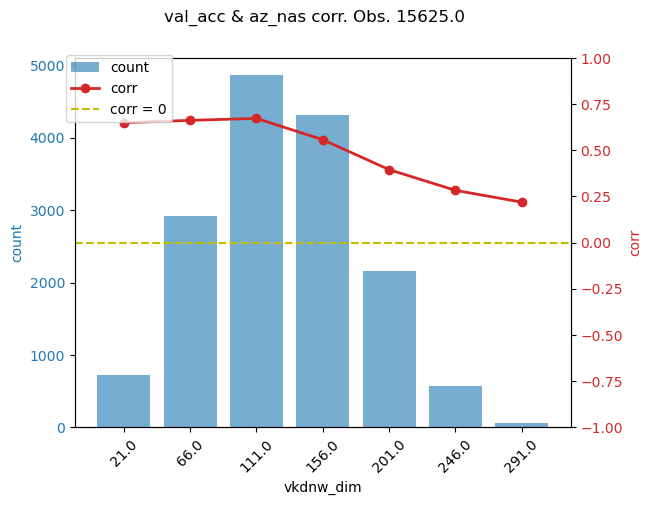

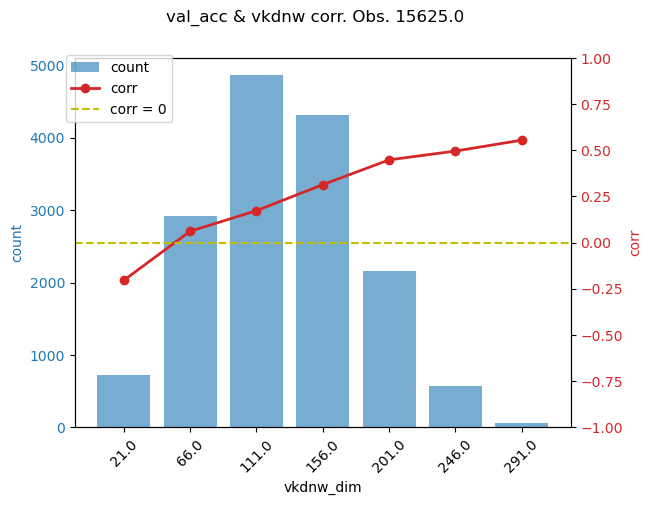

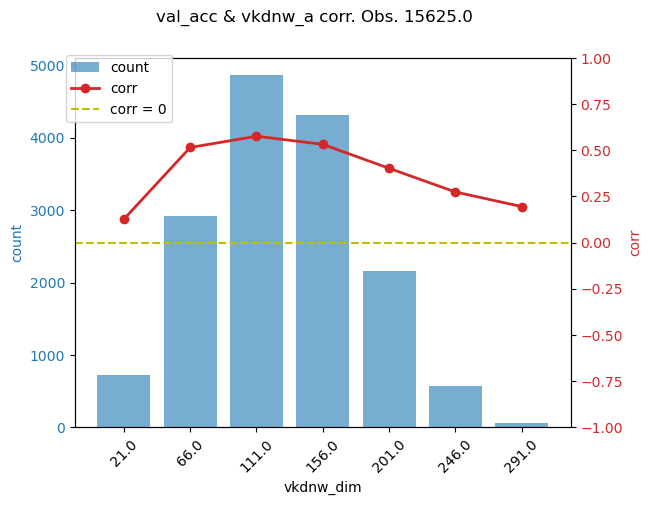

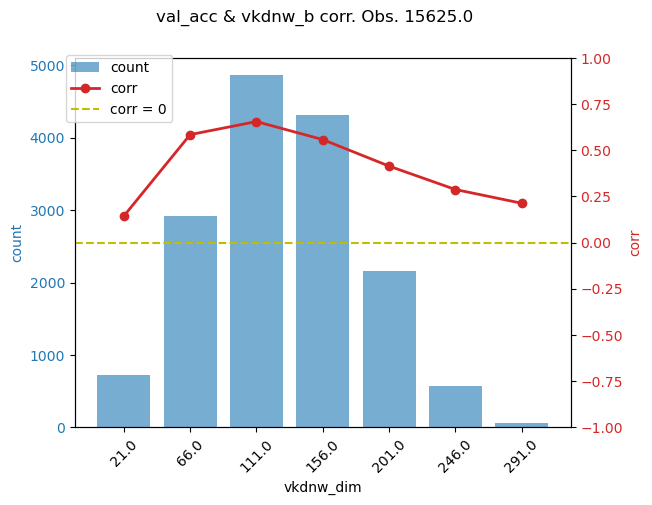

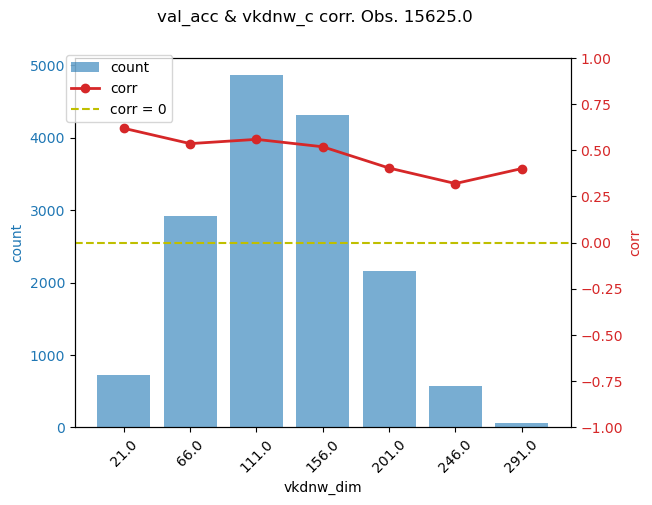

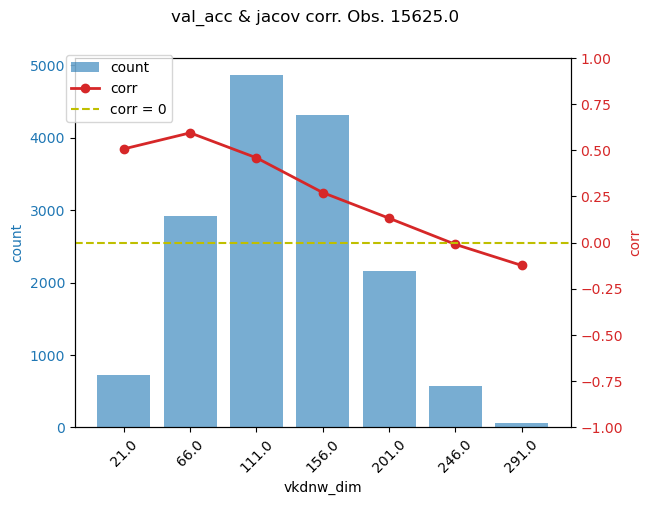

ValueError: Input contains NaN.

In [11]:
log = pd.DataFrame(columns=['pred_name', 'kendall', 'spearman', 'pearson', 'gain_norm','gain_exp', 'gain_log', 'auc_roc', 'auc_pr', 'auc_pr10'])
for pred in ['az_nas', 'vkdnw', 'vkdnw_a', 'vkdnw_b', 'vkdnw_c'] + ['jacov', 'gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas', 'zen']:
    results_all.loc[results_all[pred]==-np.inf, pred] = -10**10
    plot_stats(get_stats(results_all, 'vkdnw_dim', 'val_acc', pred), 'vkdnw_dim', 'val_acc', pred)
    log = pd.concat([
        log,
        pd.DataFrame(get_metrics(results_all, pred, show_plot=False)),
    ])

In [13]:
# ALL NETS
log.sort_values('kendall')

,pred_name,kendall,spearman,pearson,gain_norm,gain_exp,gain_log,auc_roc,auc_pr,auc_pr10
0,vkdnw,0.575178,0.771375,0.464547,0.991816,0.934523,0.935555,0.632528,0.910515,0.093142
0,vkdnw_c,0.699781,0.880773,0.676972,0.989012,0.932577,0.934444,0.670640,0.917105,0.092990
0,vkdnw_a,0.701309,0.886674,0.665882,0.991325,0.934158,0.934766,0.671037,0.917366,0.093042
0,vkdnw_b,0.717061,0.899100,0.665626,0.992143,0.937870,0.934442,0.672029,0.917647,0.093078
0,az_nas,0.740806,0.912621,0.748883,0.990372,0.934510,0.932904,0.678305,0.918407,0.092972


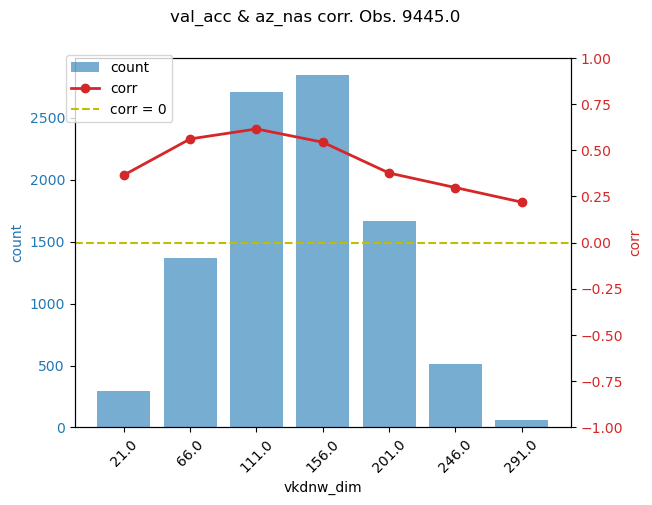

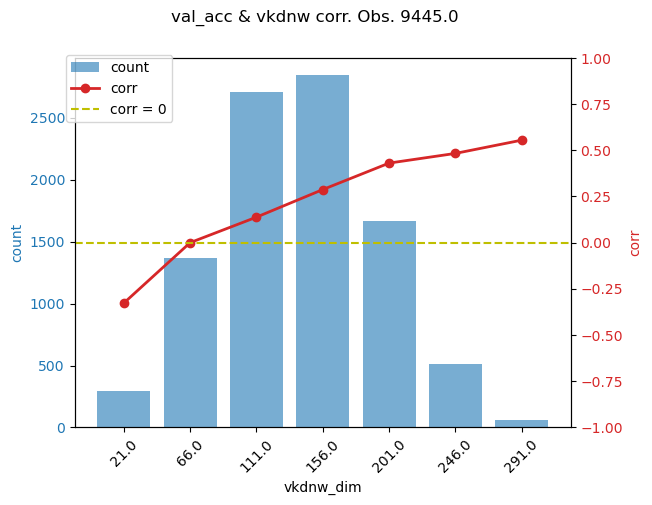

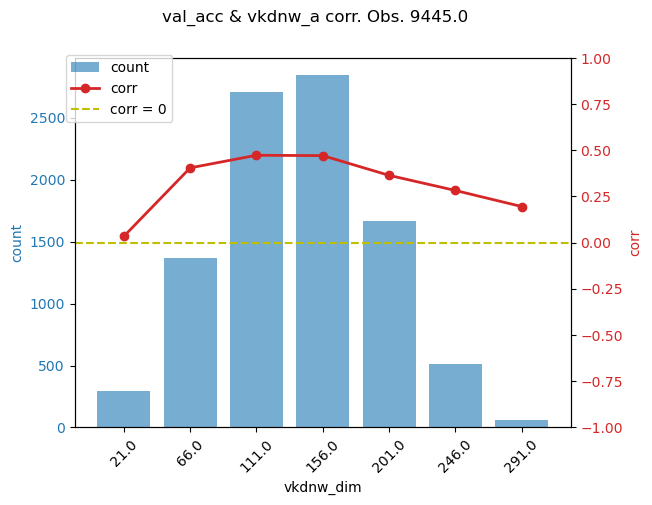

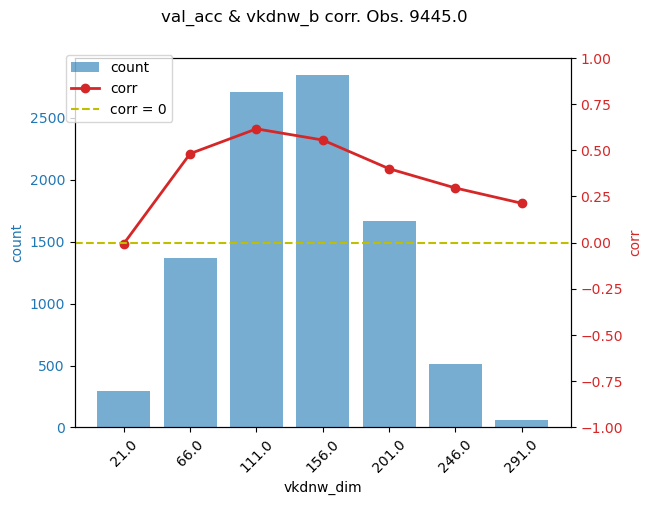

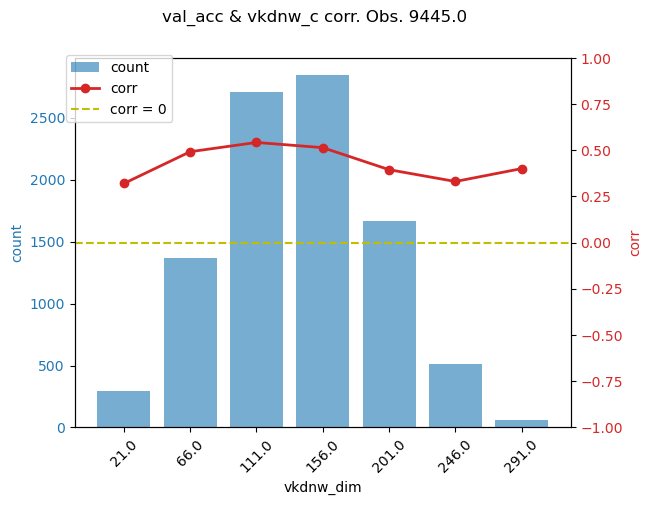

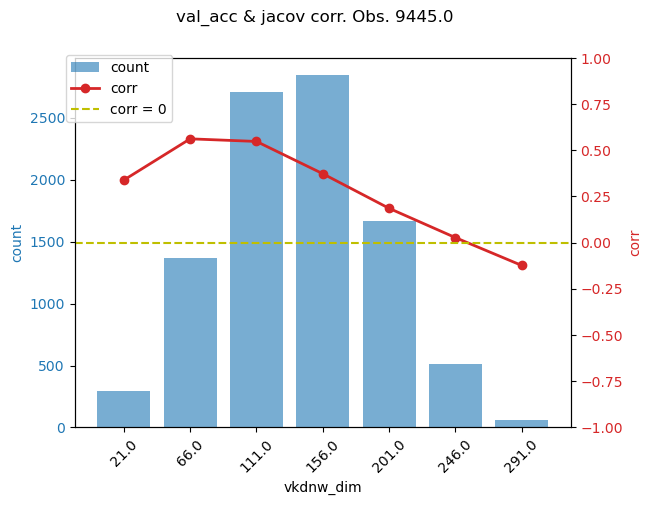

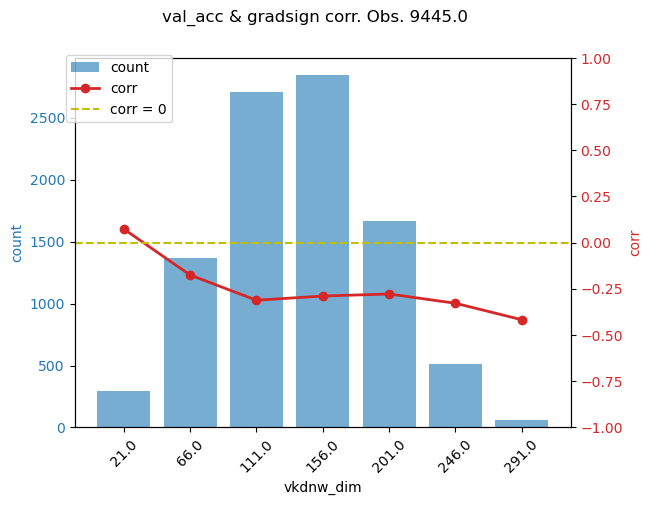

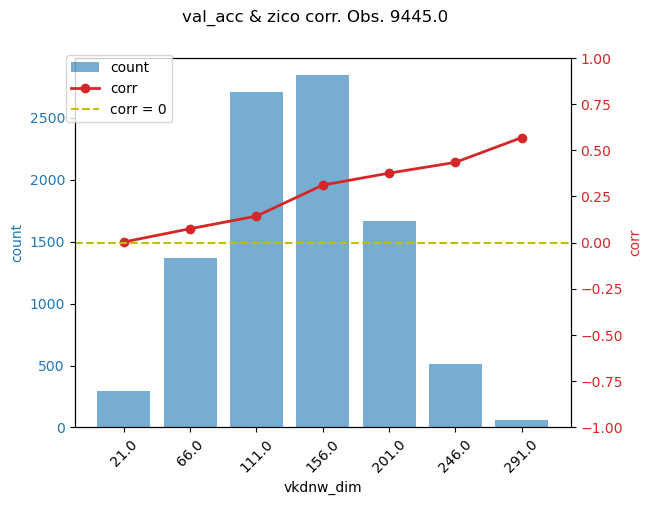

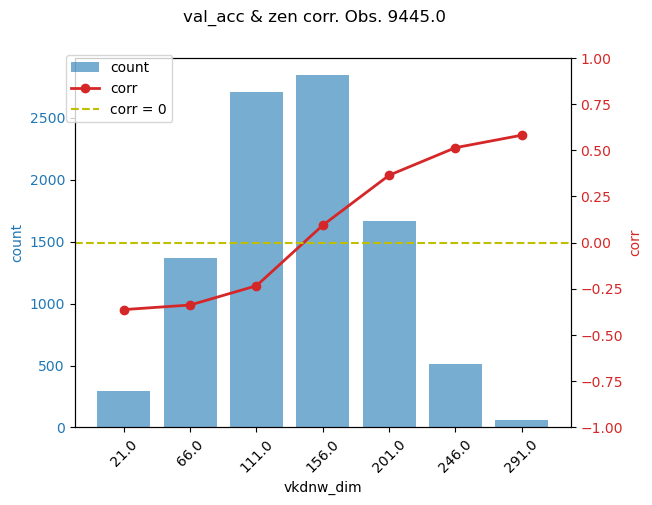

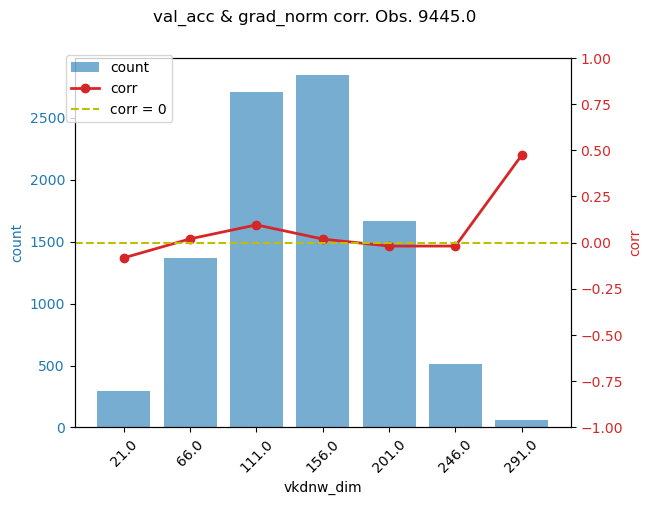

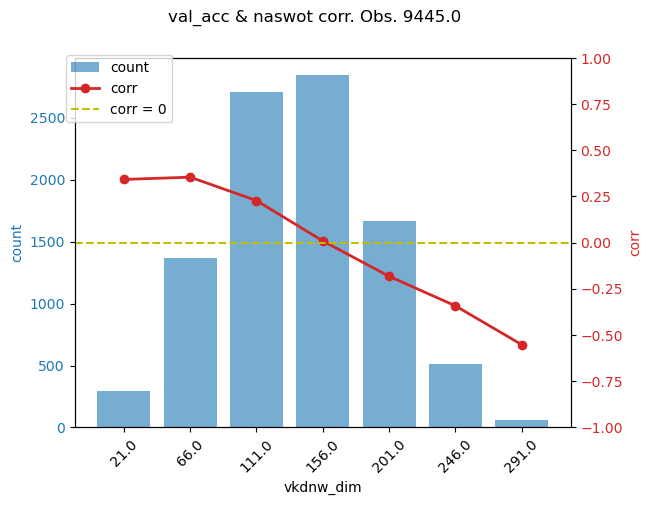

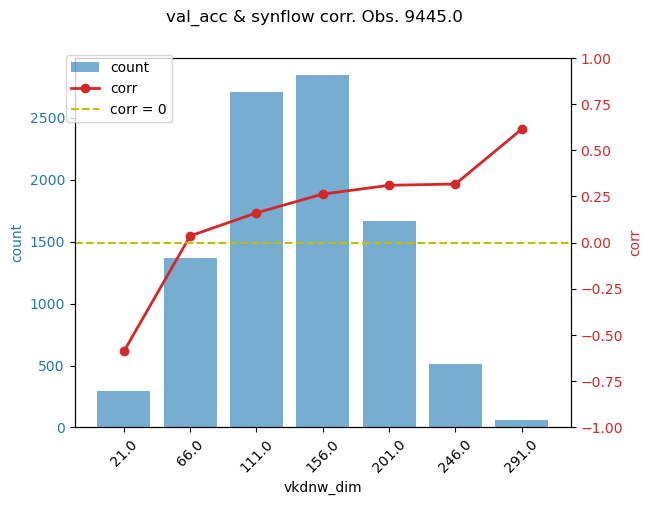

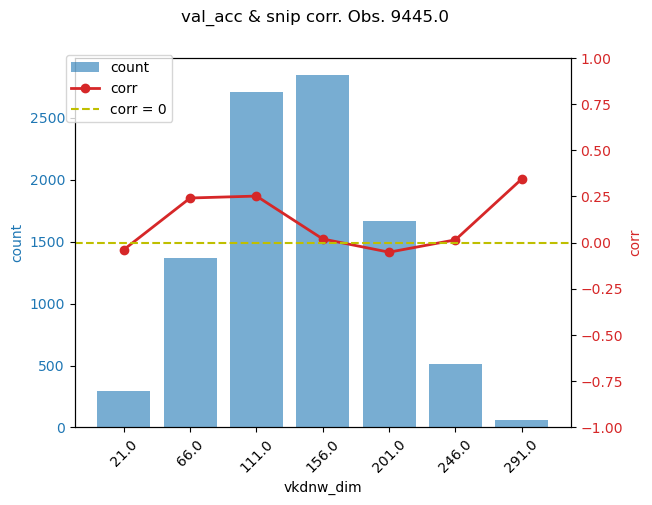

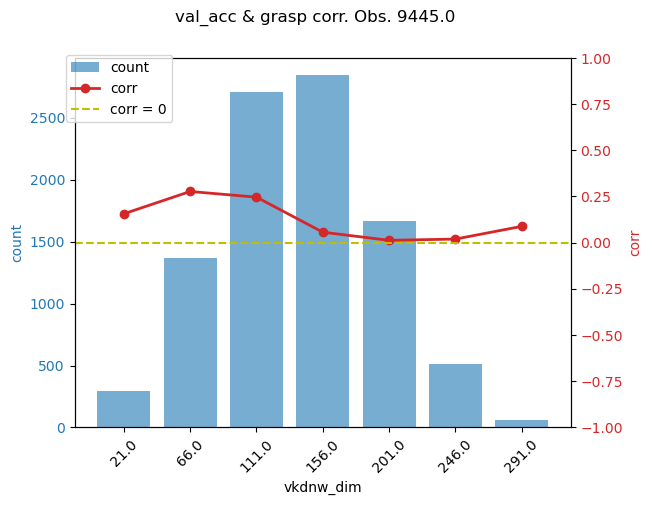

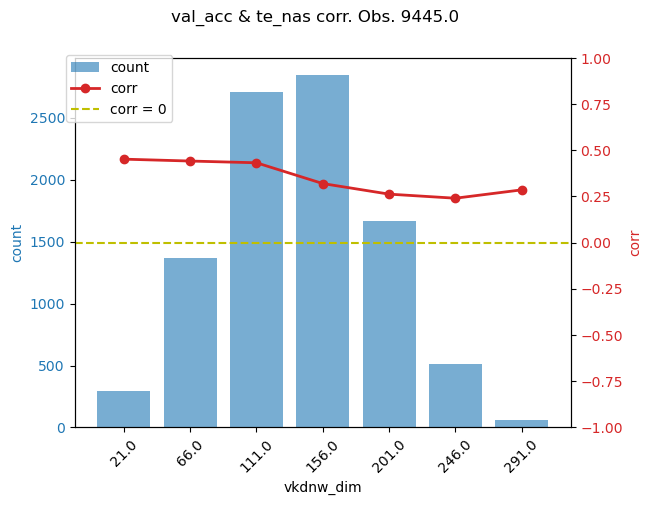

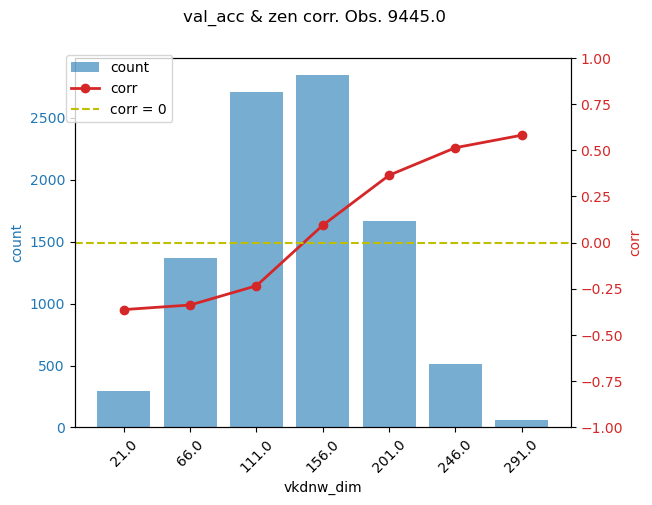

In [17]:
log = pd.DataFrame(columns=['pred_name', 'kendall', 'spearman', 'pearson', 'gain_norm','gain_exp', 'gain_log', 'auc_roc', 'auc_pr', 'auc_pr10'])
for pred in ['az_nas', 'vkdnw', 'vkdnw_a', 'vkdnw_b', 'vkdnw_c'] + ['jacov', 'gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas', 'zen']:
    results_all.loc[results_all[pred]==-np.inf, pred] = -10**10
    plot_stats(get_stats(results_all, 'vkdnw_dim', 'val_acc', pred), 'vkdnw_dim', 'val_acc', pred)
    log = pd.concat([
        log,
        pd.DataFrame(get_metrics(results_all, pred, show_plot=False)),
    ])

In [16]:
results_all['jacov'] = results_all['jacov'].fillna(np.min(results_all['jacov']))

In [18]:
log.sort_values('kendall', ascending=False)

,pred_name,kendall,spearman,pearson,gain_norm,gain_exp,gain_log,auc_roc,auc_pr,auc_pr10
0,vkdnw_b,0.729698,0.907322,0.829004,0.992143,0.937870,0.934442,0.618080,0.921617,0.093128
0,az_nas,0.720051,0.898491,0.824802,0.990372,0.934510,0.932904,0.617642,0.921421,0.093032
0,vkdnw_c,0.714697,0.890083,0.850027,0.989139,0.932577,0.934444,0.616550,0.921236,0.093050
0,vkdnw_a,0.685623,0.873855,0.827277,0.991325,0.934158,0.934766,0.615359,0.921068,0.093094
0,vkdnw,0.619208,0.814875,0.795129,0.991816,0.934523,0.935555,0.608511,0.920066,0.093216
0,jacov,0.617398,0.801424,0.617767,0.968130,0.922237,0.906690,0.611439,0.918452,0.091937
0,zico,0.604260,0.799376,0.648010,0.992560,0.937417,0.935400,0.608872,0.919867,0.093084
0,te_nas,0.581928,0.774160,0.815625,0.983747,0.927878,0.928446,0.607381,0.918968,0.092665
0,naswot,0.570271,0.761135,0.135913,0.981296,0.918260,0.926549,0.608428,0.918788,0.092583
0,synflow,0.560724,0.757825,0.066040,0.990475,0.928936,0.938562,0.604153,0.918797,0.093004


In [19]:
log.sort_values('auc_pr10', ascending=False)

,pred_name,kendall,spearman,pearson,gain_norm,gain_exp,gain_log,auc_roc,auc_pr,auc_pr10
0,vkdnw,0.619208,0.814875,0.795129,0.991816,0.934523,0.935555,0.608511,0.920066,0.093216
0,vkdnw_b,0.729698,0.907322,0.829004,0.992143,0.937870,0.934442,0.618080,0.921617,0.093128
0,vkdnw_a,0.685623,0.873855,0.827277,0.991325,0.934158,0.934766,0.615359,0.921068,0.093094
0,zico,0.604260,0.799376,0.648010,0.992560,0.937417,0.935400,0.608872,0.919867,0.093084
0,vkdnw_c,0.714697,0.890083,0.850027,0.989139,0.932577,0.934444,0.616550,0.921236,0.093050
0,az_nas,0.720051,0.898491,0.824802,0.990372,0.934510,0.932904,0.617642,0.921421,0.093032
0,synflow,0.560724,0.757825,0.066040,0.990475,0.928936,0.938562,0.604153,0.918797,0.093004
0,te_nas,0.581928,0.774160,0.815625,0.983747,0.927878,0.928446,0.607381,0.918968,0.092665
0,naswot,0.570271,0.761135,0.135913,0.981296,0.918260,0.926549,0.608428,0.918788,0.092583
0,jacov,0.617398,0.801424,0.617767,0.968130,0.922237,0.906690,0.611439,0.918452,0.091937


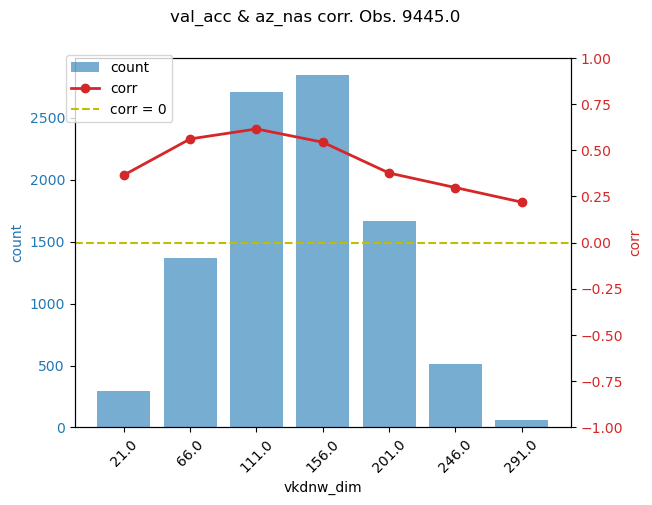

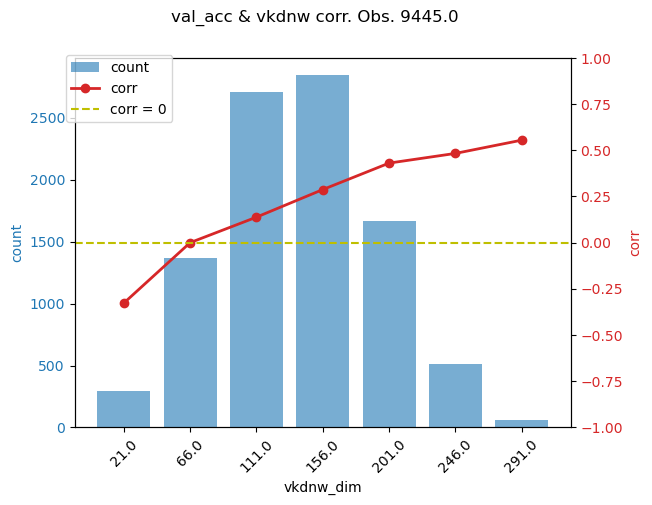

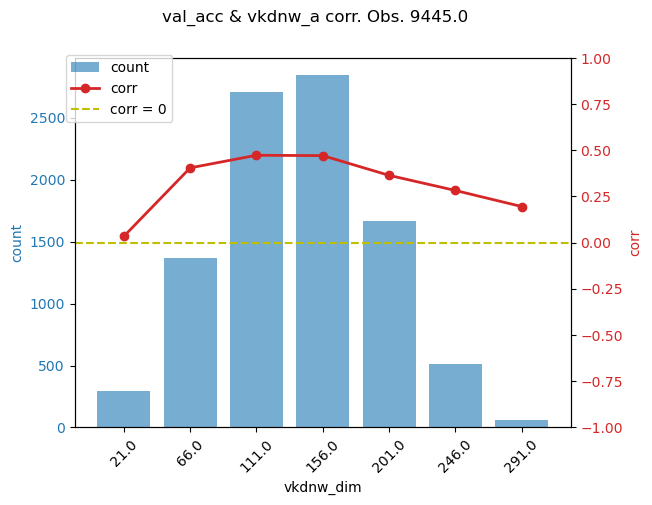

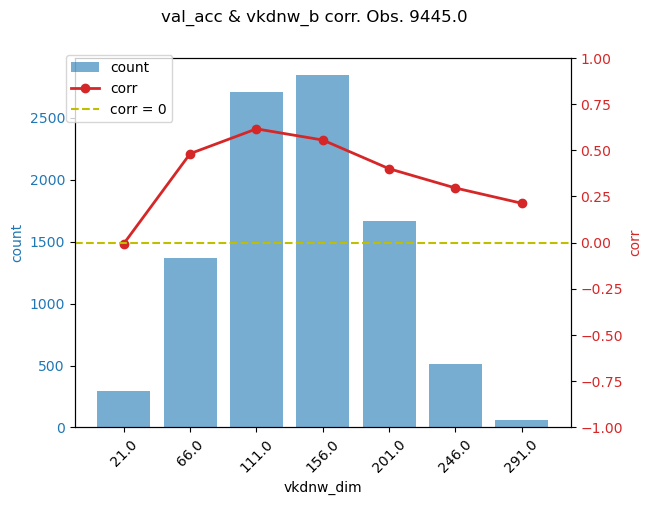

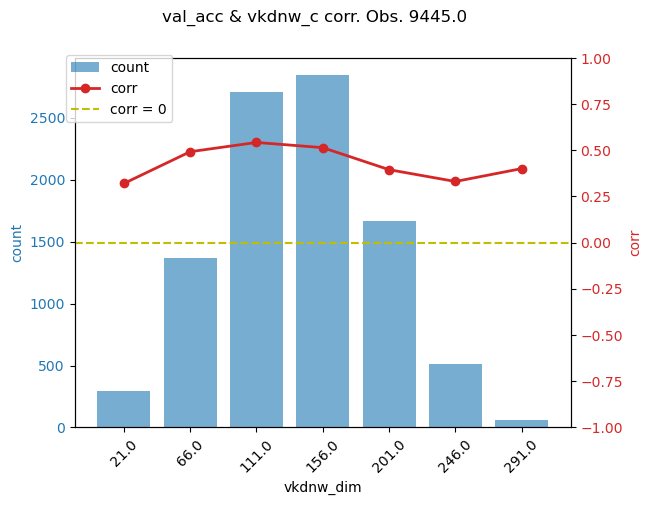

In [98]:
log = pd.DataFrame(columns=['pred_name', 'kendall', 'spearman', 'pearson', 'gain_norm','gain_exp', 'gain_log', 'auc_roc', 'auc_pr', 'auc_pr10'])
for pred in ['az_nas', 'vkdnw', 'vkdnw_a', 'vkdnw_b', 'vkdnw_c']:
    plot_stats(get_stats(results_all, 'vkdnw_dim', 'val_acc', pred), 'vkdnw_dim', 'val_acc', pred)
    log = pd.concat([
        log,
        pd.DataFrame(get_metrics(results_all, pred, show_plot=False)),
    ])

In [94]:
print(log.sort_values('auc_pr10', ascending=False))

  pred_name   kendall  spearman   pearson  gain_norm  gain_exp  gain_log  \
0     vkdnw  0.575178  0.771375  0.464547   0.991816  0.934523  0.935555   
0   vkdnw_b  0.717061  0.899100  0.665626   0.992143  0.937870  0.934442   
0   vkdnw_a  0.701309  0.886674  0.665882   0.991325  0.934158  0.934766   
0   vkdnw_c  0.699781  0.880773  0.676972   0.989012  0.932577  0.934444   
0    az_nas  0.740806  0.912621  0.748883   0.990372  0.934510  0.932904   

    auc_roc    auc_pr  auc_pr10  
0  0.632528  0.910515  0.093142  
0  0.672029  0.917647  0.093078  
0  0.671037  0.917366  0.093042  
0  0.670640  0.917105  0.092990  
0  0.678305  0.918407  0.092972  


In [ ]:
# TODO: filter only architectures as in GRAF; implement AZ-NAS into GRAF

In [ ]:
# TODO: by combnining rankings, you lose scalability through the rank() transformation. so you may get better correlation, but gain can still be worse